In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime as dt


from tensorflow.keras.layers import Dense, Dropout
from keras.layers import GRU
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
df = pd.read_csv("/content/drive/MyDrive/EICHERMOT.csv") #Read the data

In [35]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,EICHERMOT,EQ,45.20,48.00,48.85,48.00,48.85,48.85,48.75,4100,1.998700e+10,NaN,NaN,NaN
1,2000-01-04,EICHERMOT,EQ,48.85,52.00,52.75,50.15,51.80,51.40,51.44,49100,2.525880e+11,NaN,NaN,NaN
2,2000-01-05,EICHERMOT,EQ,51.40,55.00,55.55,51.05,55.55,55.55,53.99,47800,2.580730e+11,NaN,NaN,NaN
3,2000-01-06,EICHERMOT,EQ,55.55,59.75,60.00,57.30,60.00,60.00,59.75,106200,6.345465e+11,NaN,NaN,NaN
4,2000-01-07,EICHERMOT,EQ,60.00,64.00,64.80,60.10,64.80,64.65,64.08,115500,7.401300e+11,NaN,NaN,NaN


In [36]:
# Extracting date and total confirmed cases columns
date_column = 'Date'  # Assuming 'Date' is the column name for date
total_turnover = 'Turnover'  # Assuming 'total_turnover' is the column name for Turnover

# Selecting only the columns of interest
data = df[[date_column, total_turnover]]

# Displaying the selected data
print(data)

            Date      Turnover
0     2000-01-03  1.998700e+10
1     2000-01-04  2.525880e+11
2     2000-01-05  2.580730e+11
3     2000-01-06  6.345465e+11
4     2000-01-07  7.401300e+11
...          ...           ...
5296  2021-04-26  3.138312e+14
5297  2021-04-27  1.251111e+14
5298  2021-04-28  4.200329e+14
5299  2021-04-29  2.918529e+14
5300  2021-04-30  1.575531e+14

[5301 rows x 2 columns]


In [37]:
data['Turnover'] = data['Turnover'].astype(int)

<ipython-input-37-ceffb9826a66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Turnover'] = data['Turnover'].astype(int)


In [38]:
data

,Date,Turnover
0,2000-01-03,19987000000
1,2000-01-04,252588000000
2,2000-01-05,258073000000
3,2000-01-06,634546500000
4,2000-01-07,740130000000
...,...,...
5296,2021-04-26,313831166760000
5297,2021-04-27,125111081850000
5298,2021-04-28,420032888260000
5299,2021-04-29,291852919420000


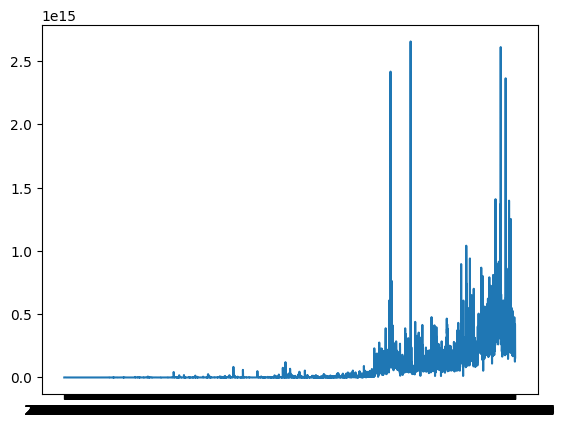

In [39]:
plt.plot(data.Date,data.Turnover)
plt.show()

In [40]:
dataset = data #Create another dataset same as the main dataset. Just to avoid replacing the main one.
dataset = dataset.set_index('Date') #Set the index of the dataset as the date
dataset = dataset['Turnover'] #We will be left with only one column Cases for our dataseta

In [41]:
dataset=dataset.to_frame() #Convert the Series into a dataframe object
dataset['Turnover_MA2']=dataset.expanding(min_periods=3).mean()  #min_periods is used to set the no. of periods for calculating MA. Mean is for calculating average.

In [42]:
dataset['EMA'] = dataset.iloc[:,0].ewm(span=3,adjust=False).mean() #ewm is used exponential moving average

In [43]:
dataset = dataset[dataset['Turnover_MA2'].notna()] #Remove the rows that have NAs

In [44]:
dataset.head()

,Turnover,Turnover_MA2,EMA
Date,,,
2000-01-05,258073000000,1.768827e+11,1.971802e+11
2000-01-06,634546500000,2.912986e+11,4.158634e+11
2000-01-07,740130000000,3.810649e+11,5.779967e+11
2000-01-10,687783500000,4.321847e+11,6.328901e+11
2000-01-11,662862000000,4.651386e+11,6.478760e+11


In [45]:
dataset

,Turnover,Turnover_MA2,EMA
Date,,,
2000-01-05,258073000000,1.768827e+11,1.971802e+11
2000-01-06,634546500000,2.912986e+11,4.158634e+11
2000-01-07,740130000000,3.810649e+11,5.779967e+11
2000-01-10,687783500000,4.321847e+11,6.328901e+11
2000-01-11,662862000000,4.651386e+11,6.478760e+11
...,...,...,...
2021-04-26,313831166760000,6.571414e+13,2.673182e+14
2021-04-27,125111081850000,6.572535e+13,1.962147e+14
2021-04-28,420032888260000,6.579222e+13,3.081238e+14


In [46]:
#Cases is the column we have to predict.
target=dataset[['Turnover']]
del dataset['Turnover']

In [47]:
x, y = dataset.values, target.values

In [48]:
x.shape

(5299, 2)

In [49]:
y.shape

(5299, 1)

In [50]:
x_scaled_set = MinMaxScaler() #Use MinMaxScaler function from sklearn.preprocessing library
y_scaled_set = MinMaxScaler()

X = x_scaled_set.fit_transform(x) #Fit to data and transform the data array x
Y = y_scaled_set.fit_transform(y.reshape(-1,1)) #Fit to data and transform the data array y. Reshape the y variable to long format

In [51]:
X_train_data=X[0:4000,]
y_train_data=Y[0:4000,]
X_test_data=X[4000:5304,]
y_test_data=Y[4000:5304,]

In [52]:
X_train_data.shape

(4000, 2)

In [53]:
y_test_data.shape

(1299, 1)

In [54]:
X_train_data = X_train_data.reshape((-1,1,2)) #Reshape train dataset to required format
X_test_data = X_test_data.reshape((-1,1,2)) #Reshape test dataset to required format

In [55]:
GRU_model = Sequential() #Use Sequential function from keras.model library
GRU_model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(1, 2))) #Add GRU model with 512 units. Note that return sequences should be true to pass on the sequences. Ensure that input_shape is inline with the inout data.
GRU_model.add(Dropout(0.2)) #Add a dropout layer to avoid overfitting.
GRU_model.add(GRU(units=256)) #Add another GRU layer with 256 units.
GRU_model.add(Dropout(0.2)) #Add another dropout layer to avoid overfitting.
GRU_model.add(Dense(1, activation='sigmoid')) #Finally, add a dense layer for getting a fully connected layer.

In [56]:
GRU_model.compile(loss='mse', optimizer='adam', metrics = ['accuracy']) #mse is mean square error which is the loss function and Adam optimizer will be the ooptimizer.

In [57]:
GRU_model.fit(X_train_data,y_train_data,batch_size=250, epochs=100, validation_split=0.15, verbose=1)
#GRU_model.save("covid_GRU.h5") #Save the model if you want for reuse.

Epoch 1/100
14/14 [==============================] - 7s 143ms/step - loss: 0.1799 - accuracy: 2.9412e-04 - val_loss: 0.0465 - val_accuracy: 0.0000e+00
Epoch 2/100
14/14 [==============================] - 1s 67ms/step - loss: 0.0167 - accuracy: 2.9412e-04 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 3/100
14/14 [==============================] - 1s 68ms/step - loss: 1.2256e-04 - accuracy: 2.9412e-04 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 4/100
14/14 [==============================] - 1s 68ms/step - loss: 1.4403e-05 - accuracy: 2.9412e-04 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 5/100
14/14 [==============================] - 1s 69ms/step - loss: 9.2419e-06 - accuracy: 2.9412e-04 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 6/100
14/14 [==============================] - 1s 67ms/step - loss: 8.3693e-06 - accuracy: 2.9412e-04 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 7/100
14/14 [==============================] - 1s 67ms/step - loss: 8.2346e-0

In [58]:
score = GRU_model.evaluate(X_test_data, y_test_data) #Evaluate model can be used to get the loss metric.
print('Score: {}'.format(score))
y_pred = GRU_model.predict(X_test_data) #Apply the built model on test data.
y_test_pred = y_scaled_set.inverse_transform(y_pred) #Use inverse transform to undo the scaling that was done before. This gives us the original values.
y_test_actual = y_scaled_set.inverse_transform(y_test_data) # Apply the inverse transform on the actual dataset for easy comparison of predicted vs actual.
#plt.plot(y_test_pred[-100:], label='Predicted') #Plot the predicted vs actual graph
#plt.plot(y_test_actual[-100:], label='Actual')
#plt.legend()
#plt.show()

41/41 [==============================] - 0s 6ms/step - loss: 0.0138 - accuracy: 0.0000e+00
Score: [0.013794265687465668, 0.0]
41/41 [==============================] - 1s 10ms/step


In [59]:
test_Dates=data.Date[4000:5304] #create an object which has the dates for the Test data.

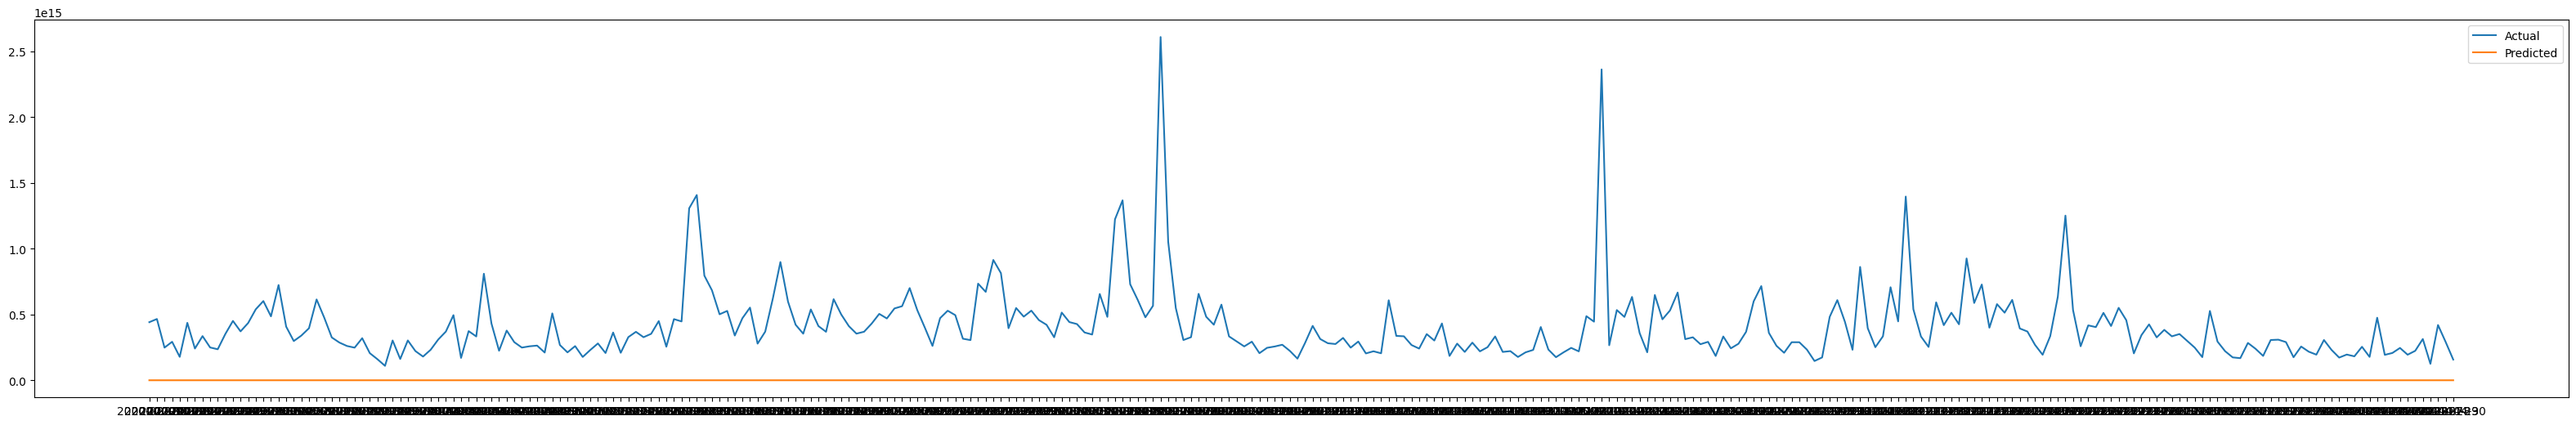

In [60]:
# Define the figure size
fig_size = (40, 6)  # Adjust width and height as needed

# Create a new figure with the specified size
plt.figure(figsize=fig_size)

# Assuming test_Dates, y_test_actual, and y_test_pred are already defined

# Slice test_Dates to match the length of y_test_actual and y_test_pred
test_Dates_sliced = test_Dates[-304:]

# Plot actual and predicted data
plt.plot(test_Dates_sliced, y_test_actual[-304:], label='Actual')
plt.plot(test_Dates_sliced, y_test_pred[-304:], label='Predicted')

# Add legend
plt.legend()

# Show the plot
plt.show()